In [4]:
import os
import torch
import torchaudio
import numpy as np
import pandas as pd

from tqdm.auto import tqdm
from scipy.spatial import distance
from textblob import TextBlob
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

In [56]:
import pandas as pd
import numpy as np
import soundfile as sf
import torch
from torch import Tensor
from torch.utils.data import Dataset
import pickle as pk
from glob import glob

In [57]:
import librosa
import librosa.display as dsp
from IPython.display import Audio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [5]:
tqdm.pandas()

DATA_DIR = './data'
PREPROC_DIR = './data'
SAMPLE_RATE = 16000

train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

train_df['array'] = None
train_df['transcription'] = None

test_df['array'] = None
test_df['transcription'] = None

In [8]:
def preproc(df):
    df = df.copy()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
    model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")
    model.to(device)
    model.eval()

    df = df.copy()
    for idx, row in tqdm(df.iterrows(),total=len(df)):
        path = row['path']
        waveform, sample_rate = torchaudio.load(os.path.join(DATA_DIR, path))
        waveform = torchaudio.functional.resample(waveform, orig_freq=sample_rate, new_freq=SAMPLE_RATE)
        inputs = processor(waveform[0], sampling_rate=SAMPLE_RATE, return_tensors="pt")
        array = inputs['input_values'].cpu().numpy().tolist()[0]
        df.at[idx,'array']=array
        with torch.no_grad():
            logits = model(**inputs.to(device)).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.batch_decode(predicted_ids)[0].lower()
        transcription = ''.join(TextBlob(transcription).correct())
        df.loc[idx,'transcription']=transcription
    return df

In [9]:
train_df_preproc = preproc(train_df)
test_df_preproc = preproc(test_df)

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5001 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  tensor = as_tensor(value)
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1881 [00:00<?, ?it/s]

In [2]:
train_df_preproc.head()

NameError: name 'train_df_preproc' is not defined

In [81]:
test_df_preproc.head()

,id,path,array,transcription
0,TEST_0000,./test/TEST_0000.wav,"[-0.11806084960699081, -0.10792392492294312, -...",i would like a new alarm lost
1,TEST_0001,./test/TEST_0001.wav,"[0.025349510833621025, 0.016926344484090805, 0...",maybe to morrow it will be called
2,TEST_0002,./test/TEST_0002.wav,"[0.0435451902449131, 0.0779065266251564, 0.016...",maybe to morrow it will be cold
3,TEST_0003,./test/TEST_0003.wav,"[0.1832374632358551, 0.11323649436235428, 0.13...",it's eleven o'clock
4,TEST_0004,./test/TEST_0004.wav,"[0.021504908800125122, 0.02967752143740654, 0....",don't forget a jacket


In [46]:
print("train 최대 길이:", train_df_preproc['transcription'].map(len).max())
print("test 최대 길이:", test_df_preproc['transcription'].map(len).max())

train 최대 길이: 40
test 최대 길이: 41


In [58]:
train = pd.read_csv('./data/train.csv')
train.head()

,id,path,label
0,TRAIN_0000,./train/TRAIN_0000.wav,1
1,TRAIN_0001,./train/TRAIN_0001.wav,2
2,TRAIN_0002,./train/TRAIN_0002.wav,4
3,TRAIN_0003,./train/TRAIN_0003.wav,5
4,TRAIN_0004,./train/TRAIN_0004.wav,4


In [59]:
train.label.groupby(train.label).count()

label
0    867
1    848
2    859
3    852
4    722
5    853
Name: label, dtype: int64

In [60]:
X = train.id.groupby(train.label).count().index
Y = train.id.groupby(train.label).count()

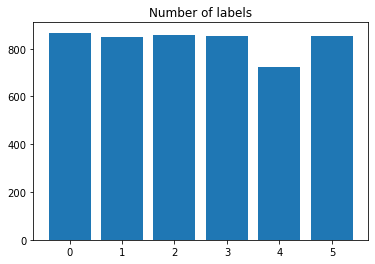

In [61]:
plt.bar(X, Y)
plt.xticks(X)
plt.title("Number of labels")
plt.show()

In [9]:
from tqdm import tqdm

len_list = []

for i in tqdm(train.id):
    y, s = librosa.load('./data/train/' + i + '.wav')
    len_list.append(len(y)/s)

100%|██████████| 5001/5001 [02:35<00:00, 32.20it/s]


<AxesSubplot:title={'center':'Length of audio'}, ylabel='Density'>

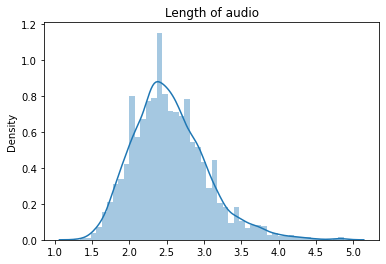

In [10]:
plt.title("Length of audio")
sns.distplot(len_list)

In [12]:
train_path = './data/train/*.wav'
test_path = './data/test/*.wav'
train_list = glob(train_path)
test_list = glob(test_path)

In [13]:
print(len(train_list))
print(len(test_list))

5001
1881


In [16]:
from sklearn.model_selection import train_test_split



In [17]:
label = train_df_preproc.label
train_features, val_features, train_targets, test_targets = train_test_split(
        train_df_preproc, label,
        train_size=0.8,
        test_size=0.2,
        # random but same for all run, also accurancy depends on the
        # selection of data e.g. if we put 10 then accuracy will be 1.0
        # in this example
        random_state=23,
        # keep same proportion of 'target' in test and target data
        stratify=label)

In [26]:
train_features.head()

,id,path,label,array,transcription
0,TRAIN_0000,./train/TRAIN_0000.wav,1,"[1.1033457517623901, 1.2063554525375366, 1.166...",it's eleven o'clock
1,TRAIN_0001,./train/TRAIN_0001.wav,2,"[-0.5838981866836548, -0.6609091758728027, -0....",the surface is sleek
2,TRAIN_0002,./train/TRAIN_0002.wav,4,"[0.27893486618995667, 0.2514820098876953, 0.24...",we'll stop in a couple of minutes
4,TRAIN_0004,./train/TRAIN_0004.wav,4,"[-0.16494052112102509, -0.15212097764015198, -...",donc will get a jacket
5,TRAIN_0005,./train/TRAIN_0005.wav,3,"[0.10450570285320282, 0.07023542374372482, 0.0...",on my way to the meeting


In [25]:
val_features.head()

,id,path,label,array,transcription
3,TRAIN_0003,./train/TRAIN_0003.wav,5,"[0.20071503520011902, 0.20071503520011902, 0.2...",maybe to morrow it will be cold
6,TRAIN_0006,./train/TRAIN_0006.wav,0,"[-0.016541067510843277, -0.024171410128474236,...",don't forget jacket
9,TRAIN_0009,./train/TRAIN_0009.wav,1,"[-0.5918120741844177, -0.5142191648483276, -0....",i's began dark
14,TRAIN_0014,./train/TRAIN_0014.wav,4,"[0.20191602408885956, 0.17535044252872467, 0.1...",that is exactly what happened
18,TRAIN_0018,./train/TRAIN_0018.wav,4,"[-0.4908468425273895, -0.40923216938972473, -0...",i wonder what this is about


In [20]:
train_features = train_features.sort_values('id')
val_features = val_features.sort_values('id')

In [21]:
train_features.id[0]

'TRAIN_0000'

In [46]:
len(train_features)

4000

In [24]:
print(train_features.label.groupby(train_features.label).count())
print(val_features.label.groupby(val_features.label).count())

label
0    693
1    678
2    687
3    682
4    578
5    682
Name: label, dtype: int64
label
0    174
1    170
2    172
3    170
4    144
5    171
Name: label, dtype: int64


In [47]:
print(type(train_features.label.to_numpy()))

<class 'numpy.ndarray'>


In [27]:
train_features.to_csv('./data/train_8_text.csv',index=False)


In [ ]:
val_features.to_csv('./data/valid_2_text.csv',index=False)

In [28]:
label = train_df_preproc.label
train_features2, val_features2, train_targets, test_targets = train_test_split(
        train_df_preproc, label,
        train_size=0.9,
        test_size=0.1,
        # random but same for all run, also accurancy depends on the
        # selection of data e.g. if we put 10 then accuracy will be 1.0
        # in this example
        random_state=23,
        # keep same proportion of 'target' in test and target data
        stratify=label)

In [29]:
train_features2 = train_features2.sort_values('id')
val_features2 = val_features2.sort_values('id')

In [30]:
print(train_features2.label.groupby(train_features2.label).count())
print(val_features2.label.groupby(val_features2.label).count())

label
0    780
1    763
2    773
3    767
4    650
5    767
Name: label, dtype: int64
label
0    87
1    85
2    86
3    85
4    72
5    86
Name: label, dtype: int64


In [31]:
print(train_features2.head())
print(val_features2.head())

           id                    path  label  \
0  TRAIN_0000  ./train/TRAIN_0000.wav      1   
1  TRAIN_0001  ./train/TRAIN_0001.wav      2   
2  TRAIN_0002  ./train/TRAIN_0002.wav      4   
4  TRAIN_0004  ./train/TRAIN_0004.wav      4   
5  TRAIN_0005  ./train/TRAIN_0005.wav      3   

                                               array  \
0  [1.1033457517623901, 1.2063554525375366, 1.166...   
1  [-0.5838981866836548, -0.6609091758728027, -0....   
2  [0.27893486618995667, 0.2514820098876953, 0.24...   
4  [-0.16494052112102509, -0.15212097764015198, -...   
5  [0.10450570285320282, 0.07023542374372482, 0.0...   

                       transcription  
0                it's eleven o'clock  
1               the surface is sleek  
2  we'll stop in a couple of minutes  
4             donc will get a jacket  
5           on my way to the meeting  
            id                    path  label  \
3   TRAIN_0003  ./train/TRAIN_0003.wav      5   
6   TRAIN_0006  ./train/TRAIN_0006.wav    

In [32]:
train_features2.to_csv('./data/train_9.csv',index=False)
val_features2.to_csv('./data/valid_1.csv',index=False)

In [41]:
t = pd.read_csv('./data/test.csv')
t.head()

,id,path
0,TEST_0000,./test/TEST_0000.wav
1,TEST_0001,./test/TEST_0001.wav
2,TEST_0002,./test/TEST_0002.wav
3,TEST_0003,./test/TEST_0003.wav
4,TEST_0004,./test/TEST_0004.wav


In [44]:
paths = t.path.to_list()
paths[0] = paths[0].replace('./','./data/')
print(paths[0])

./data/test/TEST_0000.wav


In [33]:
label = train_df_preproc.label
train_features3, val_features3, train_targets, test_targets = train_test_split(
        train_df_preproc, label,
        train_size=0.95,
        test_size=0.05,
        # random but same for all run, also accurancy depends on the
        # selection of data e.g. if we put 10 then accuracy will be 1.0
        # in this example
        random_state=1000,
        # keep same proportion of 'target' in test and target data
        stratify=label)

In [34]:
train_features3 = train_features3.sort_values('id')
val_features3 = val_features3.sort_values('id')

In [35]:
print(train_features3.label.groupby(train_features3.label).count())
print(val_features3.label.groupby(val_features3.label).count())

label
0    824
1    805
2    816
3    809
4    686
5    810
Name: label, dtype: int64
label
0    43
1    43
2    43
3    43
4    36
5    43
Name: label, dtype: int64


In [36]:
print(train_features3.head())
print(val_features3.head())

           id                    path  label  \
0  TRAIN_0000  ./train/TRAIN_0000.wav      1   
1  TRAIN_0001  ./train/TRAIN_0001.wav      2   
2  TRAIN_0002  ./train/TRAIN_0002.wav      4   
3  TRAIN_0003  ./train/TRAIN_0003.wav      5   
4  TRAIN_0004  ./train/TRAIN_0004.wav      4   

                                               array  \
0  [1.1033457517623901, 1.2063554525375366, 1.166...   
1  [-0.5838981866836548, -0.6609091758728027, -0....   
2  [0.27893486618995667, 0.2514820098876953, 0.24...   
3  [0.20071503520011902, 0.20071503520011902, 0.2...   
4  [-0.16494052112102509, -0.15212097764015198, -...   

                       transcription  
0                it's eleven o'clock  
1               the surface is sleek  
2  we'll stop in a couple of minutes  
3    maybe to morrow it will be cold  
4             donc will get a jacket  
            id                    path  label  \
28  TRAIN_0028  ./train/TRAIN_0028.wav      4   
38  TRAIN_0038  ./train/TRAIN_0038.wav    

In [37]:
train_features3.to_csv('./data/train_95_text.csv',index=False)
val_features3.to_csv('./data/valid_05_text.csv',index=False)


In [82]:
test_df_preproc.to_csv('./data/test_text.csv',index=False)

In [41]:
train_features3.head()

,id,path,label,array,transcription
0,TRAIN_0000,./train/TRAIN_0000.wav,1,"[1.1033457517623901, 1.2063554525375366, 1.166...",it's eleven o'clock
1,TRAIN_0001,./train/TRAIN_0001.wav,2,"[-0.5838981866836548, -0.6609091758728027, -0....",the surface is sleek
2,TRAIN_0002,./train/TRAIN_0002.wav,4,"[0.27893486618995667, 0.2514820098876953, 0.24...",we'll stop in a couple of minutes
3,TRAIN_0003,./train/TRAIN_0003.wav,5,"[0.20071503520011902, 0.20071503520011902, 0.2...",maybe to morrow it will be cold
4,TRAIN_0004,./train/TRAIN_0004.wav,4,"[-0.16494052112102509, -0.15212097764015198, -...",donc will get a jacket


In [42]:
train_features3.transcription[0]

"it's eleven o'clock"

In [1]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, AutoModelForSequenceClassification, AutoTokenizer
model = AutoModelForSequenceClassification.from_pretrained('tae898/emoberta-large')
token = AutoTokenizer.from_pretrained('tae898/emoberta-large')

/opt/conda/lib/python3.8/site-packages/pandas/compat/_optional.py:161: UserWarning: Pandas requires version '2.7.1' or newer of 'numexpr' (version '2.7.0' currently installed).
  warnings.warn(msg, UserWarning)


In [ ]:
tokenizer(sen1, 
                          sen2, 
                          return_tensors='pt', 
                          max_length=MAX_LEN, 
                          padding='max_length',
                          truncation=True,
                          add_special_tokens=True,
                          return_token_type_ids=True)

In [2]:
import numpy as np
MAX_LEN = 41
item = token('',return_tensors='pt', 
                          max_length=MAX_LEN, 
                          padding='max_length',
                          truncation=True,
                          add_special_tokens=True,
                          return_token_type_ids=True)

In [7]:
item['input_ids']

tensor([[0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [8]:
item['input_ids'][0][None]

tensor([[0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [98]:
a = model(item['input_ids'])

In [101]:
a.logits.shape

torch.Size([1, 7])

In [ ]:
def layer_freeze(w2v2, total_layer,frz_layer) :
    w2v2.dropout = nn.Identity()
    w2v2.lm_head = nn.Identity()
    for para in w2v2.parameters():
        para.requires_grad = False

    for name ,child in w2v2.named_children():
        if name == 'wav2vec2':
            for nam,chil in child.named_children():
                if nam == 'encoder' :
                    for na,chi in chil.named_children():
                        if na == 'layers' :
                            for i in range(total_layer):
                                if frz_layer == -1 :
                                    for para in chi.parameters():
                                        para.requires_grad = True
                                elif frz_layer <= i :
                                    for i,para in enumerate(chi[i].parameters()):
                                        para.requires_grad = True
    return w2v2                                                 

In [104]:
model.classifier

RobertaClassificationHead(
  (dense): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Linear(in_features=1024, out_features=7, bias=True)
)

In [91]:
import torch.nn as nn
model.classifier.dropout = nn.Identity()
model.classifier.out_proj = nn.Linear(1024,64)

In [90]:
def nlp_finetune(emoberta,proj_dim) :
    emoberta.classifier.dropout = nn.Identity()
    emoberta.classifier.out_proj = nn.Identity()
    
    for para in emoberta.parameters():
        para.requires_grad = False
    
    emoberta.classifier.out_proj = nn.Linear(1024,proj_dim)
    return emoberta

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [84]:
for name ,child in model.named_children():
    if name == 'classifier' 

RobertaClassificationHead(
  (dense): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Linear(in_features=1024, out_features=7, bias=True)
)

In [62]:
a

SequenceClassifierOutput(loss=None, logits=tensor([[ 2.5200,  2.9632, -0.9061,  0.4828, -1.2299, -2.8644, -1.6932]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [74]:
def tokenize_function(example):
    MAX_LEN = 41
    return token(example,return_tensors='pt', 
                          max_length=MAX_LEN, 
                          padding='max_length',
                          truncation=True,
                          add_special_tokens=True,
                          return_token_type_ids=True)

In [80]:
token_data = train_features3.applymap(lambda x : tokenize_function(x))

ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [77]:
token_data

NameError: name 'token_data' is not defined

In [ ]:
MAX_LEN = 41
item = token(train_features3.transcription,return_tensors='pt', 
                          max_length=MAX_LEN, 
                          padding='max_length',
                          truncation=True,
                          add_special_tokens=True,
                          return_token_type_ids=True)

In [5]:
import numpy as np
a = np.empty()
b = np.array([[1,2,3,4]])
c = np.array([[2,3,4,5]])
a = np.concatenate((a,b),axis=0)
a = np.concatenate((a,c),axis=0)
print(a)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [10]:
import torch
a = torch.empty(0)
b = torch.tensor([[1,2,3,4]])
c = torch.tensor([[2,3,4,5]])
a = torch.cat((a,b),0)
a = torch.cat((a,c),0)
print(len(a))
print(a.shape)
for i in a :
    print(i)

2
torch.Size([2, 4])
tensor([1., 2., 3., 4.])
tensor([2., 3., 4., 5.])


In [191]:
import torch
a = torch.arange(1,64*30+1).reshape(1,2,32,30)  # >>> (50,4,5)

In [192]:
a

tensor([[[[   1,    2,    3,  ...,   28,   29,   30],
          [  31,   32,   33,  ...,   58,   59,   60],
          [  61,   62,   63,  ...,   88,   89,   90],
          ...,
          [ 871,  872,  873,  ...,  898,  899,  900],
          [ 901,  902,  903,  ...,  928,  929,  930],
          [ 931,  932,  933,  ...,  958,  959,  960]],

         [[ 961,  962,  963,  ...,  988,  989,  990],
          [ 991,  992,  993,  ..., 1018, 1019, 1020],
          [1021, 1022, 1023,  ..., 1048, 1049, 1050],
          ...,
          [1831, 1832, 1833,  ..., 1858, 1859, 1860],
          [1861, 1862, 1863,  ..., 1888, 1889, 1890],
          [1891, 1892, 1893,  ..., 1918, 1919, 1920]]]])

In [196]:
print(a.unfold(2,16,16).unfold(3,15,15).shape)
print(a.unfold(2,16,16).unfold(3,15,15).reshape(1,-1,16,15).shape)
fold = a.unfold(2,16,16).unfold(3,15,15).reshape(1,-1,16,15).reshape(1,-1,16*15)
print(fold[0,1])

torch.Size([1, 2, 2, 2, 16, 15])
torch.Size([1, 8, 16, 15])
tensor([ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         59,  60,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
         88,  89,  90, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
        146, 147, 148, 149, 150, 166, 167, 168, 169, 170, 171, 172, 173, 174,
        175, 176, 177, 178, 179, 180, 196, 197, 198, 199, 200, 201, 202, 203,
        204, 205, 206, 207, 208, 209, 210, 226, 227, 228, 229, 230, 231, 232,
        233, 234, 235, 236, 237, 238, 239, 240, 256, 257, 258, 259, 260, 261,
        262, 263, 264, 265, 266, 267, 268, 269, 270, 286, 287, 288, 289, 290,
        291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 316, 317, 318, 319,
        320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 346, 347, 348,
    

In [197]:
80//16


5

In [150]:
a.unfold(0,4,4).unfold(1,5,5).reshape(-1,4,5)#.unfold(1,1,1)..shape#.unfold(0,4,4).shape   #torch.Size([20, 10, 5])

tensor([[[   1,    2,    3,    4,    5],
         [  51,   52,   53,   54,   55],
         [ 101,  102,  103,  104,  105],
         [ 151,  152,  153,  154,  155]],

        [[   6,    7,    8,    9,   10],
         [  56,   57,   58,   59,   60],
         [ 106,  107,  108,  109,  110],
         [ 156,  157,  158,  159,  160]],

        [[  11,   12,   13,   14,   15],
         [  61,   62,   63,   64,   65],
         [ 111,  112,  113,  114,  115],
         [ 161,  162,  163,  164,  165]],

        [[  16,   17,   18,   19,   20],
         [  66,   67,   68,   69,   70],
         [ 116,  117,  118,  119,  120],
         [ 166,  167,  168,  169,  170]],

        [[  21,   22,   23,   24,   25],
         [  71,   72,   73,   74,   75],
         [ 121,  122,  123,  124,  125],
         [ 171,  172,  173,  174,  175]],

        [[  26,   27,   28,   29,   30],
         [  76,   77,   78,   79,   80],
         [ 126,  127,  128,  129,  130],
         [ 176,  177,  178,  179,  180]],

    

./data/tae_test.pk


In [3]:
import pandas as pd
a = pd.read_csv('./data/train_95.csv')
b = pd.read_csv('./data/train_95_text.csv')

/opt/conda/lib/python3.8/site-packages/pandas/compat/_optional.py:161: UserWarning: Pandas requires version '2.7.1' or newer of 'numexpr' (version '2.7.0' currently installed).
  warnings.warn(msg, UserWarning)


In [4]:
a.id == b.id

0       True
1       True
2       True
3       True
4       True
        ... 
4745    True
4746    True
4747    True
4748    True
4749    True
Name: id, Length: 4750, dtype: bool

In [5]:
import pickle as pk
with open('./exp_result/emotion_wav2vec2_ecapa_ep500_bs128_lr0.0001_w2v2_TL12_frz3_ECAPA_sec2_large960h/emotion_wav2vec2_ecapa_ep500_bs128_lr0.0001_w2v2_TL12_frz3_ECAPA_sec2_large960h_0_test.pk','rb') as f :
    data = pk.load(f)

In [8]:
data['TEST_0000']

tensor([-3.5931e-01, -5.3774e-01,  1.5433e-03,  2.4787e-01, -1.9911e+00,
        -1.0509e+00, -1.4639e+00, -2.7565e-01,  5.4115e-01,  4.5843e-01,
         1.2530e+00,  4.2078e-01,  2.6696e+00,  4.6399e-01,  4.3135e-01,
        -4.8051e-01, -2.0536e-01, -3.9583e-01,  1.0609e+00,  2.5568e-01,
         2.1997e+00,  6.3506e-01, -1.3137e+00, -3.5281e-01, -2.0038e-01,
         6.1724e-01, -3.1791e+00,  3.1838e-01, -1.8482e+00, -4.5679e-02,
        -2.5816e-01,  2.7996e-01,  1.0450e+00, -8.3801e-01, -3.7754e-01,
         7.5415e-01,  9.6495e-01, -3.5338e-02,  4.1465e-01,  4.9571e-01,
         1.3334e+00,  5.9965e-01, -1.0873e+00,  4.0840e-01,  1.5291e+00,
         1.6057e+00, -9.0559e-01,  5.4135e-01,  4.0631e-01, -6.1569e-01,
        -1.1371e+00,  2.1222e+00, -1.0538e+00, -1.1360e+00,  3.5057e-01,
         1.6477e+00,  1.5685e+00, -1.3485e+00, -2.1581e+00,  2.3268e+00,
         1.1194e+00,  3.5719e-01, -1.4060e+00,  9.3288e-01,  4.0640e-01,
        -1.2192e+00, -3.1115e-01,  1.2318e+00,  1.4

In [10]:
import pandas as pd

train_df = pd.read_csv('./data/train_95_text.csv')
valid_df = pd.read_csv('./data/valid_05_text.csv')
test_df = pd.read_csv('./data/test_text.csv')

In [11]:
from transformers import BertTokenizer, RobertaModel, AutoModel
from transformers import BertModel, RobertaTokenizer, AutoTokenizer

In [12]:
train_df.head()

,id,path,label,array,transcription
0,TRAIN_0000,./train/TRAIN_0000.wav,1,"[1.1033457517623901, 1.2063554525375366, 1.166...",it's eleven o'clock
1,TRAIN_0001,./train/TRAIN_0001.wav,2,"[-0.5838981866836548, -0.6609091758728027, -0....",the surface is sleek
2,TRAIN_0002,./train/TRAIN_0002.wav,4,"[0.27893486618995667, 0.2514820098876953, 0.24...",we'll stop in a couple of minutes
3,TRAIN_0003,./train/TRAIN_0003.wav,5,"[0.20071503520011902, 0.20071503520011902, 0.2...",maybe to morrow it will be cold
4,TRAIN_0004,./train/TRAIN_0004.wav,4,"[-0.16494052112102509, -0.15212097764015198, -...",donc will get a jacket


In [13]:
train_trans = train_df.transcription
valid_trans = valid_df.transcription
test_trans = test_df.transcription

In [15]:
for i,t in enumerate(train_trans) :
    if i == 0 :
        print(t)

it's eleven o'clock


In [17]:
import torch
tokenizer = AutoTokenizer.from_pretrained('tae898/emoberta-large')
bert = AutoModel.from_pretrained("tae898/emoberta-large")
bert.pooler = torch.nn.Identity()
MAX_LEN = 41

Some weights of the model checkpoint at tae898/emoberta-large were not used when initializing RobertaModel: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at tae898/emoberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
import tqdm

In [30]:
train_pooled_list = []

for i, trans in tqdm(enumerate(train_trans)) :
    
    item = tokenizer(trans,return_tensors='pt', 
                              max_length=MAX_LEN, 
                              padding='max_length',
                              truncation=True,
                              add_special_tokens=True,
                              return_token_type_ids=True)
    input_ids = item['input_ids'][0][None]

    attention_mask = item['attention_mask'][0][None]
    _, pooled_output = bert(input_ids= input_ids, attention_mask=attention_mask,return_dict=False)
    pooled_output = pooled_output[0]
    pooled_output, _  = torch.max(pooled_output,0)
    pooled_output = pooled_output.detach().numpy()
    train_pooled_list.append(pooled_output)


KeyboardInterrupt



In [37]:

valid_pooled_list = []

for  trans in tqdm.tqdm(valid_trans) :
    
    item = tokenizer(trans,return_tensors='pt', 
                              max_length=MAX_LEN, 
                              padding='max_length',
                              truncation=True,
                              add_special_tokens=True,
                              return_token_type_ids=True)
    input_ids = item['input_ids'][0][None]

    attention_mask = item['attention_mask'][0][None]
    _, pooled_output = bert(input_ids= input_ids, attention_mask=attention_mask,return_dict=False)
    pooled_output = pooled_output[0]
    pooled_output, _  = torch.max(pooled_output,0)
    pooled_output = pooled_output.detach().numpy()
    valid_pooled_list.append(pooled_output)

100% 251/251 [27:36<00:00,  6.60s/it]


In [ ]:
test_pooled_list = []

for i, trans in tqdm(enumerate(test_trans)) :
    
    item = tokenizer(trans,return_tensors='pt', 
                              max_length=MAX_LEN, 
                              padding='max_length',
                              truncation=True,
                              add_special_tokens=True,
                              return_token_type_ids=True)
    input_ids = item['input_ids'][0][None]

    attention_mask = item['attention_mask'][0][None]
    _, pooled_output = bert(input_ids= input_ids, attention_mask=attention_mask,return_dict=False)
    pooled_output = pooled_output[0]
    pooled_output, _  = torch.max(pooled_output,0)
    pooled_output = pooled_output.detach().numpy()
    test_pooled_list.append(pooled_output)

In [28]:
print(input_ids)
print(attention_mask)
print(pooled_output.detach().numpy())
print(input_ids)
print(attention_mask.shape)
print(pooled_output[0].shape)

tensor([[    0,   405,    18, 19353,  1021,   108, 17036,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
[[[-1.3277221   1.113966    0.3361138  ... -0.64048487 -1.9860672
   -0.4000356 ]
  [-0.50834113  0.9026009   0.61659724 ... -0.42300978 -1.7451657
   -0.1691581 ]
  [-0.99572664  0.9638553   0.3892484  ... -0.5185581  -1.5061496
   -0.30227453]
  ...
  [-0.64973897  0.9461859   0.49465573 ... -0.642866   -1.7621087
   -0.2309233 ]
  [-0.64973897  0.9461859   0.49465573 ... -0.642866   -1.7621087
   -0.2309233 ]
  [-0.64973897  0.9461859   0.49465573 ... -0.642866   -1.7621087
   -0.2309233 ]]]
tensor([[    0,   405, 